In [1]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import optax
import jax.lax as lax

## Part 1: Forward simulation in 1D

Simplified 1D model: only have x dimension (u)
\begin{aligned}
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{\partial p}{\partial x}  + \nu \frac{\partial^2 u}{\partial x^2} \\\\
\end{aligned}

Heat evolution:
\begin{align}
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} = \kappa \nabla^2 T
\end{align}

In [2]:
Lx = 1
nx = 100
dx = Lx / (nx - 1)
dt = 0.001
nu = 10
diffusivity = 0.001
dpdx = 0.5

x = jnp.linspace(0, Lx, nx)




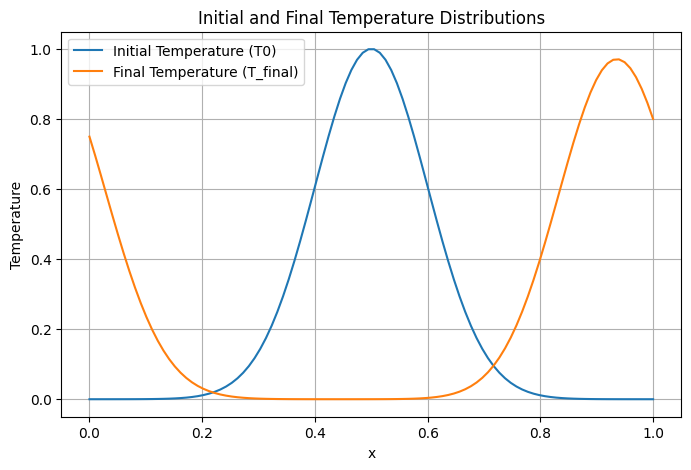

In [3]:
T0 = jnp.exp(-0.5 * ((x - 0.5) / 0.1) ** 2) # initial temperature distribution
u = 1.0 * jnp.ones_like(x) # Initial velocity field

@jax.jit
def heat_evolution(T, u, dx, dt, diffusivity):
    dTdx = (jnp.roll(T, -1) - jnp.roll(T, 1)) / (2 * dx)
    d2Tdx2 = (jnp.roll(T, -1) - 2*T + jnp.roll(T, 1)) / dx**2
    T_rhs = -u * dTdx + diffusivity * d2Tdx2
    T_new = T + dt * T_rhs
    return T_new

@jax.jit
def velocity_evolution(u, dx, dt, nu, dpdx):
    dudx = (jnp.roll(u, -1) - jnp.roll(u, 1)) / (2 * dx)
    d2udx2 = (jnp.roll(u, -1) - 2*u + jnp.roll(u, 1)) / dx**2
    u_rhs = -u * dudx - dpdx + nu * d2udx2
    u_new = u + dt * u_rhs
    return u_new

def run_forward_phase(T0, u0, dx, dt, diffusivity, nu, dpdx, num_steps):
    T, u = T0.copy(), u0.copy()
    for _ in range(num_steps):
        T = heat_evolution(T, u, dx, dt, diffusivity)
        u = velocity_evolution(u, dx, dt, nu, dpdx)
    return T 

T_final = run_forward_phase(T0, u, dx, dt, diffusivity, nu, dpdx, num_steps=500)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, T0, label='Initial Temperature (T0)')
plt.plot(x, T_final, label='Final Temperature (T_final)')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('Initial and Final Temperature Distributions')
plt.legend()
plt.grid(True)
plt.show()


## Part 2: 2D shallow water equations:

\begin{aligned}
\frac{\partial h}{\partial t} + \nabla \cdot (h \vec{u}) = 0 \\
\frac{\partial \vec{u}}{\partial t} + (\vec{u} \cdot \nabla)\vec{u} + g \nabla h = \nu \nabla^2 \vec{u}

\end{aligned}
where:
-  h(x,y,t)  is the fluid depth,
-  \vec{u} = (u,v) is the horizontal velocity,
-  g  is gravity,
-  \nu  is kinematic viscosity.


Heat evolution: 
\begin{align}
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} = \kappa \nabla^2 T
\end{align}

In [4]:
# Parameters
f = 1e-4    # Coriolis parameter (s^-1)
nu = 10    # Viscosity
diffusivity = 0.001
Lx = 10 # Domain size in x (m)
Ly = 10 # Domain size in y (m)
nx = 100     # Grid points in x
ny = 100    # Grid points in y
H = 100 # Initial height (m)
g = 9.81

# Create grid
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
X, Y = jnp.meshgrid(x, y, indexing='ij')
dt = 0.1*min(dx, dy)/np.sqrt(g*H)

In [5]:
print(dt)

0.0003225004327343944


In [6]:
def gradient(field, dx, dy):
    df_dx = (jnp.roll(field, -1, axis=0) - jnp.roll(field, 1, axis=0)) / (2 * dx)
    df_dy = (jnp.roll(field, -1, axis=1) - jnp.roll(field, 1, axis=1)) / (2 * dy)
    return df_dx, df_dy

def laplacian(field, dx, dy):
    d2f_dx2 = (jnp.roll(field, -1, axis=0) - 2 * field + jnp.roll(field, 1, axis=0)) / dx**2
    d2f_dy2 = (jnp.roll(field, -1, axis=1) - 2 * field + jnp.roll(field, 1, axis=1)) / dy**2
    return d2f_dx2 + d2f_dy2


In [7]:
def shallow_water_rhs(t, state, args):
    u, v, h, T = state
    g, nu, kappa, dx, dy = args

    # Gradients
    du_dx, du_dy = gradient(u, dx, dy)
    dv_dx, dv_dy = gradient(v, dx, dy)
    dh_dx, dh_dy = gradient(h, dx, dy)
    dT_dx, dT_dy = gradient(T, dx, dy)

    # Laplacians
    lap_u = laplacian(u, dx, dy)
    lap_v = laplacian(v, dx, dy)
    lap_T = laplacian(T, dx, dy)

    # Nonlinear advection
    adv_u = u * du_dx + v * du_dy
    adv_v = u * dv_dx + v * dv_dy
    adv_T = u * dT_dx + v * dT_dy

    # Continuity (height)
    uh = u * h
    vh = v * h
    duh_dx, duh_dy = gradient(uh, dx, dy)
    dvh_dx, dvh_dy = gradient(vh, dx, dy)
    dh_dt = - (duh_dx + dvh_dy)

    # Momentum with gravity
    du_dt = - adv_u - g * dh_dx + nu * lap_u
    dv_dt = - adv_v - g * dh_dy + nu * lap_v

    # Heat transport
    dT_dt = - adv_T + kappa * lap_T

    '''
    jax.debug.print("t={:.2f}", t)
    jax.debug.print("T stats: min={:.2e}, max={:.2e}", jnp.min(T), jnp.max(T))
    jax.debug.print("h stats: min={:.2e}, max={:.2e}", jnp.min(h), jnp.max(h))  
    jax.debug.print("u stats: min={:.2e}, max={:.2e}", jnp.min(u), jnp.max(u))
    jax.debug.print("v stats: min={:.2e}, max={:.2e}", jnp.min(v), jnp.max(v))
    '''
    return du_dt, dv_dt, dh_dt, dT_dt


In [8]:
@jax.jit
def simulate(u0, v0, h0, T0, t_end):
    initial_state = (u0, v0, h0, T0)

    term = diffrax.ODETerm(shallow_water_rhs)
    solver = diffrax.Dopri5()

    args = (g, nu, diffusivity, dx, dy)  # typical g = 9.81 m/s^2

    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=0,
        t1=t_end,
        dt0=dt,
        y0=initial_state,
        args=args,
        max_steps=1000000,
    )

    u_final, v_final, h_final, T_final = solution.ys
    return u_final, v_final, h_final, T_final

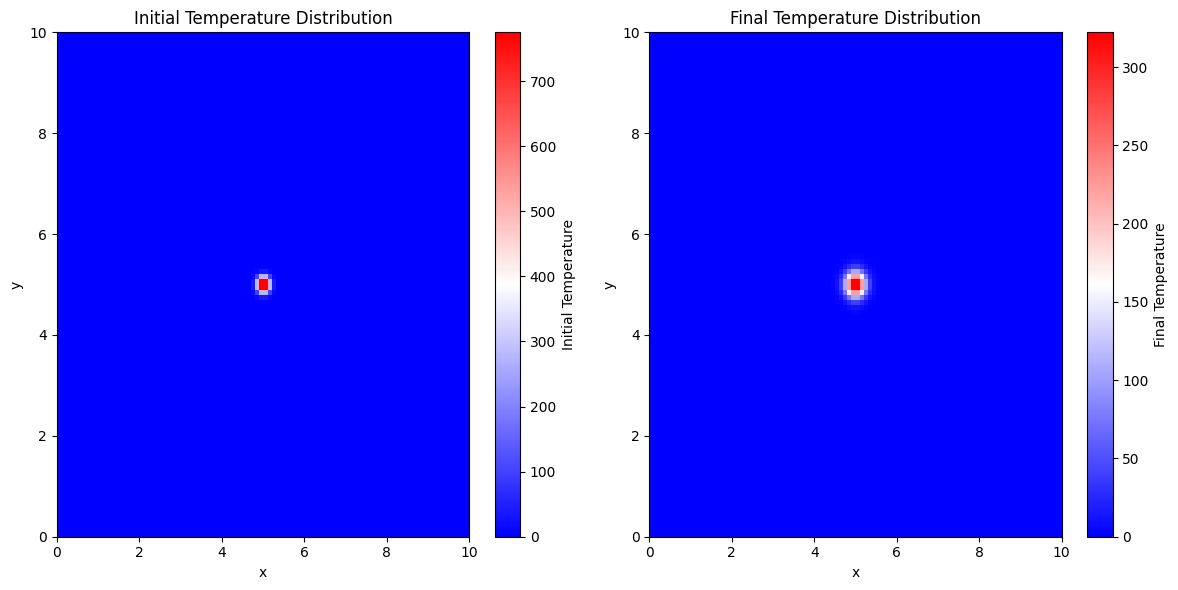

In [9]:
# Gaussian parameters
x0 = Lx / 2  # center x
y0 = Ly / 2  # center y
sigma_x = 0.1  # std in x
sigma_y = 0.1  # std in y

# 2D Gaussian
gaussian = 1e3 * jnp.exp(-(((X - x0) ** 2) / (2 * sigma_x ** 2) +
                    ((Y - y0) ** 2) / (2 * sigma_y ** 2)))

# Initial conditions
u0 = jnp.zeros_like(X)
v0 = jnp.zeros_like(X)
h0 = jnp.ones_like(X)  # flat water depth
T0 = jnp.array(gaussian, dtype=jnp.float32)  
u_final, v_final, h_final, T_final = simulate(u0, v0, h0, T0, t_end=10)

# Plotting
plt.figure(figsize=(12,6))
# plot initial and final temperature distributions 
plt.subplot(1, 2, 1)
plt.imshow(T0, extent=(0, Lx, 0, Ly), origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='Initial Temperature')
plt.title('Initial Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.imshow(T_final[0], extent=(0, Lx, 0, Ly), origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='Final Temperature')
plt.title('Final Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Part 3 optimization

In [10]:
# New target: shifted + stretched
x0_target = Lx * 0.3  # Near left border
y0_target = Ly * 0.7  # Near top border

sigma_x_target = 1.5  
sigma_y_target = 0.5   

amplitude_target = 1e3 / 10  # Scale down to balance area

T_target = amplitude_target * jnp.exp(-(((X - x0_target) ** 2) / (2 * sigma_x_target ** 2)
      + ((Y - y0_target) ** 2) / (2 * sigma_y_target ** 2))
)

print("T_target stats:", jnp.min(T_target), jnp.max(T_target))
T_initial = T0 #Lx = 10 =Ly, nx = ny = 100

print(T_target.shape)

T_target stats: 0.0 99.79614
(100, 100)


In [11]:
def loss_fn(u0, v0, h0, T0, T_target):
    u_final, v_final, h_final, T_final = simulate(u0, v0, h0, T0, t_end=10)

    jax.debug.print("T_final stats: min={:.2e}, max={:.2e}", jnp.min(T_final), jnp.max(T_final))
    jax.debug.print("h_final stats: min={:.2e}, max={:.2e}", jnp.min(h_final), jnp.max(h_final))

    if T_final[-1].shape != T_target.shape:
        raise ValueError(f"Shape mismatch: T_final {T_final.shape} vs T_target {T_target.shape}")

    heat_loss = jnp.mean(jnp.abs(T_final[-1] - T_target))


    if jnp.isnan(heat_loss):
        print("NaN in heat loss!")
    
    return heat_loss


def loss_fn(u0, v0, h0, T0, T_target, target_center=(Lx/2, Ly/2), alpha=1.0):
    u_final, v_final, h_final, T_final = simulate(u0, v0, h0, T0, t_end=10)

    jax.debug.print("T_final stats: min={:.2e}, max={:.2e}", jnp.min(T_final), jnp.max(T_final))
    jax.debug.print("h_final stats: min={:.2e}, max={:.2e}", jnp.min(h_final), jnp.max(h_final))

    if T_final[-1].shape != T_target.shape:
        raise ValueError(f"Shape mismatch: T_final {T_final.shape} vs T_target {T_target.shape}")

    heat_loss = jnp.mean(jnp.abs(T_final[-1] - T_target))

    # Calulate location of heat pulse: Compute weighted center of T_final[-1]
    T = T_final[-1]
    total_heat = jnp.sum(T) + 1e-8  # avoid divide by zero

    x_center = jnp.sum(X * T) / total_heat
    y_center = jnp.sum(Y * T) / total_heat

    # Distance squared to target
    dx = x_center - target_center[0]
    dy = y_center - target_center[1]
    loc_loss = dx**2 + dy**2

    # Combined loss
    total_loss = heat_loss + alpha * loc_loss

    if jnp.isnan(total_loss):
        print("NaN in total loss!")

    return total_loss


In [12]:
def optimize_coupled_system():
    key = jax.random.PRNGKey(42)
    
    # initial guess for velocity fields
    u0 = 1e-1 * jax.random.normal(key, (nx, ny))
    v0 = 1e-1 * jax.random.normal(key, (nx, ny))

    # Fixed initial height and temperature
    h0 =  jnp.ones((nx, ny))
    T0 = T_initial  # your Gaussian or some baseline

    optimizer = optax.adam(learning_rate=0.1)
    
    opt_state = optimizer.init((u0, v0))

    losses = []
    grad_fn = jax.value_and_grad(
        lambda u0, v0: loss_fn(u0, v0, h0, T0, T_target),
        argnums=(0, 1)
    )

    for i in range(10):
        loss, grads = grad_fn(u0, v0)

        print(f"Iteration {i}: loss = {loss:.6f}")
        print("grads u0 stats:", jnp.min(grads[0]), jnp.max(grads[0]), "grads v0 stats:", jnp.min(grads[1]), jnp.max(grads[1]))
        updates, opt_state = optimizer.update(grads, opt_state, (u0, v0))
        u0, v0 = optax.apply_updates((u0, v0), updates)

        losses.append(loss)
    return u0, v0, losses

u0_opt, v0_opt, loss_history = optimize_coupled_system()

# Simulate with optimized velocity
h0 = jnp.ones((nx, ny))
T0 = T_initial

u_final, v_final, h_final, T_final_opt = simulate(u0_opt, v0_opt, h0, T0, t_end=10)

print(f"\nHeat transport MSE: {jnp.mean((T_final_opt - T_target)**2):.6f}")
print(f"Final max velocity: {jnp.max(jnp.sqrt(u_final**2 + v_final**2)):.2f} m/s")
print(f"Final mean height: {jnp.mean(h_final):.4f} m")


T_final stats: min=0.00e+00, max=3.33e+02
h_final stats: min=1.00e+00, max=1.00e+00
Iteration 0: loss = 5.134429
grads u0 stats: -7.004563e-05 1.5068223e-05 grads v0 stats: -9.51392e-05 -1.1881048e-05
T_final stats: min=-6.11e+01, max=2.76e+02
h_final stats: min=1.00e+00, max=1.00e+00
Iteration 1: loss = 7.250939
grads u0 stats: 0.0018974381 0.0026221042 grads v0 stats: 0.0015469429 0.0021371266
T_final stats: min=-1.44e+00, max=3.22e+02
h_final stats: min=9.99e-01, max=1.00e+00
Iteration 2: loss = 5.259856
grads u0 stats: 0.0005000754 0.00071039353 grads v0 stats: 0.00046611624 0.0006655845
T_final stats: min=-2.01e+01, max=3.04e+02
h_final stats: min=1.00e+00, max=1.00e+00
Iteration 3: loss = 5.622818
grads u0 stats: -0.001726803 -0.0012659526 grads v0 stats: -0.0017572892 -0.0012877234
T_final stats: min=-4.20e+01, max=3.04e+02
h_final stats: min=1.00e+00, max=1.00e+00
Iteration 4: loss = 5.969179
grads u0 stats: -0.001573961 -0.001142531 grads v0 stats: -0.002053722 -0.0015053343
T

Text(0, 0.5, 'Y')

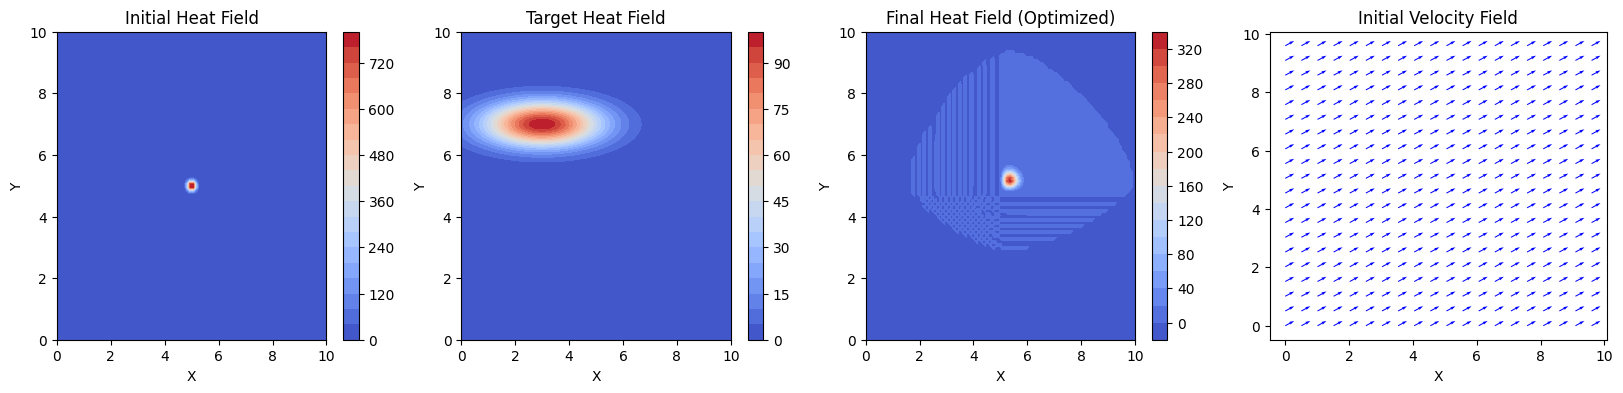

In [13]:
# plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

im1 = axes[0].contourf(X, Y, T_initial, levels=20, cmap='coolwarm')
axes[0].set_title('Initial Heat Field')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].contourf(X, Y, T_target, levels=20, cmap='coolwarm')
axes[1].set_title('Target Heat Field')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].contourf(X, Y, T_final_opt[0], levels=20, cmap='coolwarm')
axes[2].set_title('Final Heat Field (Optimized)')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
plt.colorbar(im3, ax=axes[2])

# Row 2: initial velocity fields
# Subsample every nth point
step = 5  # or 3, 4 — adjust for fewer arrows

# Use slicing
X_sub = X[::step, ::step]
Y_sub = Y[::step, ::step]
u_sub = u_final[0][::step, ::step]
v_sub = v_final[0][::step, ::step]

im4 = axes[3].quiver(X_sub, Y_sub, u_sub, v_sub, color='blue', scale=1.5)
axes[3].set_title('Initial Velocity Field')
axes[3].set_xlabel('X')
axes[3].set_ylabel('Y')

In [14]:
import sys

def print_dependencies():
    print("\n=== Dependencies ===")
    print(f"Python: {sys.version.split()[0]}")
    import jax, diffrax, optax, matplotlib, numpy
    print(f"JAX: {jax.__version__}")
    print(f"Diffrax: {diffrax.__version__}")
    print(f"Optax: {optax.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Numpy: {numpy.__version__}")
    print("====================\n")

print_dependencies()



=== Dependencies ===
Python: 3.13.1
JAX: 0.6.2
Diffrax: 0.7.0
Optax: 0.2.5
Matplotlib: 3.10.3
Numpy: 2.3.1

